# Install requirements

In [2]:
!pip install -r requirements.txt

# Intro to ODEs

## Rabbit population
Imagine that some rabbits make their way onto an island that doesn't have any predators. We intially have N rabbits and after a month they make K more. After another month, those N+K rabbits make L rabbits and we observe that $\frac{N+k}{N} = \frac{L}{N+K}$, that is, the number of new-born rabbits is proportional to the number of rabbits currently on the island. If we denote time with the variable t, we've observed the following relationship
$$
\frac{\partial N(t)}{\partial t} = k N(t),
$$
that is, the rate of change of the population is proportional to the population. You may recognise this as the continuous version of the gemoetric progression $x_n = q x_{n-1}$. This equation is simple enough such that we can solve it (see https://www.mathsisfun.com/calculus/differential-equations.html) and obtain an explicit representation of $N(t)=Ce^{kt}$ for some value $C$. Most commonly, though, it is either very difficult or impossible to find an explicit solution for an equation of this kind, for example it is unclear how to solve (if it is possible at all)
$$
\left(\frac{\partial N(t)}{\partial t}\right)^3 + y^2 = N(t) y
$$
without using some advanced methods. Even if we do not knowing the exact representation, we can still do interesting things with these equations. For example, we can re-arrange and start from some initial value N(0) and (approximately) simulate how these change in time by iteratively applying the below equation for some small time difference $\Delta t$
$$
N(t + \Delta t) = N(t) + \sqrt[3]{N(t) y - y^2}\Delta t.
$$
This is known as the Euler method (https://en.wikipedia.org/wiki/Euler_method) and while it doesn't give great results due to the accumulation of errors, it shows how we can avoid requiring an explicit representation of N(t).

# Making the ODE "Neural"

Looking at the previous section, we are inspired to ask ourselves the question "what happens if we tried to model the derivative (with respect to time $t$) of the function $z(x)$ taking our inputs $x$ into our outputs $y$ with a neural network?". That is, we imagine that our function $z$ is some continuous transformation that starts at time $t=0$ at $x$ and arrives at $y$ at time $t=1$ and are interested in how it changes as we vary $t$ from 0 to 1. If we're fitting to data anyway, we'll learn some very complex and inscrutable function, so does it provide any advantages over trying to fit the function $z$ itself? The answer, as you may expect, is yes and we will spend the rest of this tutorial looking at various ways in which this is hepful. 

Firstly, though, let's briefly talk about exactly how we can learn the parameters $\theta$ of our network $f_{\theta}$ under this new setting. We will still employ gradient-based optimisation, which means that we need to find the quantity
$$
\frac{\partial L(z(1), y)}{\partial \theta}
$$
where $L$ is the loss function (e.g. least squares), and $z(t)$ is the aforementioned continuous process, with $z(0) = x$ and $z(1) = \hat{y}$, that is, our prediction. Now, we know that $z(T) = z(0) + \int_0^T f_{\theta}(z(t), t) dt$, for some $0 <= T <= 1$, this is exactly us using our learnt derivative to find the value at time $t=T$ and is the analogue of running our "network" $G$ forward. Notice how we can set $T$ to be any real value, this is why we interpret Neural ODEs as having infinitely many hidden layers. As you may guess at this point, in order to fit our weights, we will need to do the equivalent of back-propagation through these infinite layers as well. This is where the concept of the adjoint state $a_z(t) = \frac{\partial L}{\partial z(t)}$ comes in - this is similar to the error signal $\delta$ in the normal neural network case. From here on out, with a bit of maths, we find the derivative of this adjoint state
$$
\frac{\partial a_z(t)}{\partial t} = -a_z(t)\frac{\partial f_{\theta}(z(t),t)}{\partial z(t)}.
$$
Just like having the derivative of $z(t)$ allowed us to calculate $z(T)$ for any $T$, we can now calculate $a_z(T)$ as well. Note that this computation is "backwards in time" - we start from the known quantity $a(1)$ and go back towards $a(T)$. Finally, by similar argument to the above, we can define other adjoints $a_{\theta}(t)$ and $a_t(t)$ to find each of $\frac{\partial L}{\partial \theta}$ and $\frac{\partial L}{\partial t}$. Unsuprisingly, we get
$$
\frac{\partial a_{\theta}}{\partial t} = -a_z(t)\frac{\partial f_{\theta}(z(t),t)}{\partial \theta}, \\
\frac{\partial a_t}{\partial t} = -a_z(t)\frac{\partial f_{\theta}(z(t),t)}{\partial t},
$$
where again, the first line is reminiscent to how we compute the gradient of $\theta$ given the error signal $\delta$ and the current hidden state $h_t = f_{\theta}(z(t), t)$, and the last line follows the functional form of the other two. One final note is that we know $\frac{\partial L}{\partial t}$ at time $t=1$ exactly (it is $a_z(1)f_{\theta}(z(1), 1)$).
With the gradients of $L$ with respect to its input parameters known, we can now minimise the function given some data.

More detail on the maths can be found here: https://ml.berkeley.edu/blog/posts/neural-odes/#training-odenets

# Implementation

We use PyTorch to define the ODENet. We will go over the implementation from https://github.com/msurtsukov/neural-ode as it is slightly more brief than the one in the original paper. First some boilerplate code

In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

We will use the following trick several times from here on. If we want to solve several ODEs (in our case one for $a_z, a_{\theta}, a_t$ each) at the same time, we can concatenate the states of each separate ODE into a single augmented state (let's call that $a_{aug}$), and taking into account the Jacobian matrix, we can find $\frac{\partial a_{aug}(t)}{\partial t}$. This allows us to run an ODE solver on the augmented state and solve for the three variables at the same time. We define a function that performs the computation of the forward pass and the adjoint derivatives first

In [2]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        # a_z in the description
        a = grad_outputs
        # Computes a_z [df/dz, df/dt, df/theta] using the augmented adjoint state [a_z, a_t, a_theta]
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

Next, we define a function that allows us to repeat the process described above for a series of times $[t_0, t_1, ..., t_N]$. This will come in useful in the next section, where we do sequence modelling.

In [3]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Finally, we define an neural network module wrapper of the function for more convenient use

In [4]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Examples

Let's look at a couple of examples of how we can apply this architecture to problems.

## Continuous-time sequence models

In this section, let's look at the first two examples in https://github.com/msurtsukov/neural-ode. First, we set up some boilerplate code.

In [5]:
def to_np(x):
    return x.detach().cpu().numpy()

def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()
    
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"assets/imgs/{name}/{i}.png")
            clear_output(wait=True)

### Simple linear ODE
We are given a two-dimensinal $\mathbf{z}(t)$, which changes according to the equation
$$
\frac{\partial \mathbf{z}}{\partial t} = \begin{bmatrix}
-0.1 z_1 - z_2 \\
z_1 - 0.1 z_2 \\
\end{bmatrix}.
$$
This looks gives us a spiral from the initial point, going closer and closer around the origin. 

In [6]:
# Restrict ODE to a linear function
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

# True function
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))
        
# Random initial guess for function
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

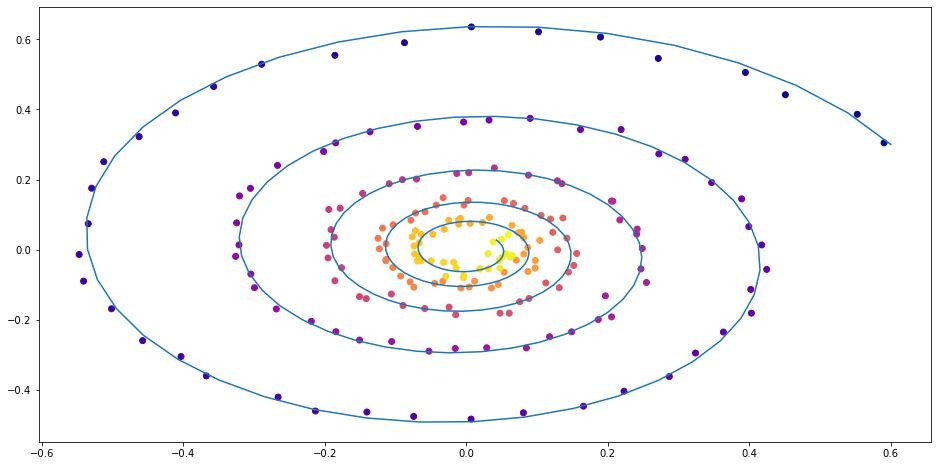

In [7]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

conduct_experiment(ode_true, ode_trained, 500, "linear")

### More complex ODE

Next we set up an ODE with more complicated dynamics. In this particular case, we will use a 2-layer neural network to produce the dynamics. That is, we have
$$
\frac{\partial \mathbf{z}}{\partial t} = f_{true}(\mathbf{z}(t), t)
$$
for some 2-layer neural network $f_{true}$.

In [8]:
# True 2-layer neural network
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

# Neural network to learn the dynamics
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

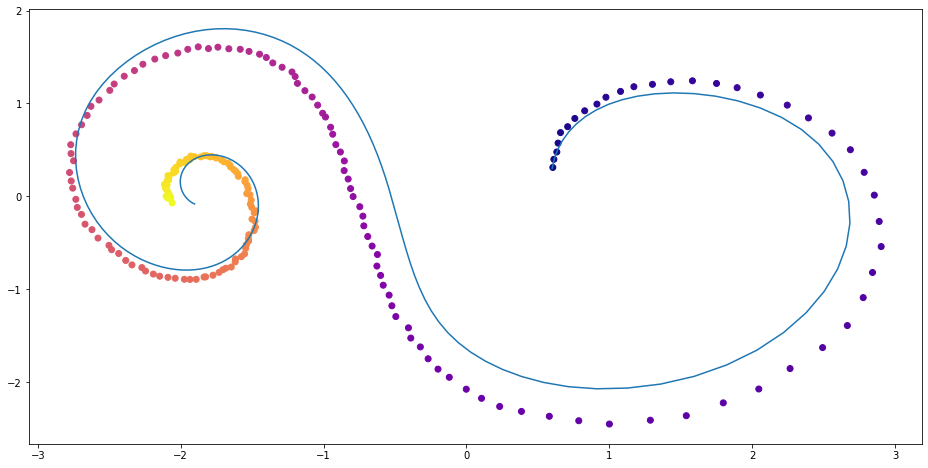

In [9]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

## Normalizing flows

The original, discrete normalizing flows approximate a probability density over a random variable $\mathbf{z}$ with a series of transformations of a simple, known density distribtuion over $\mathbf{z}_0$. That is, let's say that $\mathbf{z}_0 $ is drawn from the standard Gaussian distribution $\mathcal{N}(\mathbf{0}, I)$. We define $\mathbf{z}_1 = r_{\theta}(\mathbf{z}_0)$ for some (differentiable) function r with parameters $\theta$ and can use the change of variable rule for probability distribution to get
$$
p_{\mathbf{z}_1}(\mathbf{z_1}) = p_{\mathbf{z}_0}(\mathbf{z_0}) \left |\det (J_{z_1z_0}) \right|
$$
where $\det$ is the determinant operator and $J_{z_1z_0}$ is the Jacobian between the two variables (more thorough definition of this can be found here https://stats.libretexts.org/Bookshelves/Probability_Theory/Book%3A_Probability_Mathematical_Statistics_and_Stochastic_Processes_(Siegrist)/03%3A_Distributions/3.07%3A_Transformations_of_Random_Variables).

We can repeat the above process over and over again to get more and more complex densities $p_{\mathbf{z}_i}$. Normalizing flows allow us to fit the parameters $\theta$ of each transformation, however they require that we compute the determinant of the Jacobians at each transformation. Unless the Jacobians have special structure, which restricts the type of transformations we can apply, this computation costs $\mathcal{O}(D^3)$, where $D$ is the number of dimensions of $\mathbf{z}$ and this can be prohibitively costly.

Luckily, if we make these transformations continuous, we no longer require to compute the determinant of the Jacobian, but instead only the sum of the diagonal elements (the trace) of the continuous equivalent. This is a $\mathcal{O}(D)$ operation, instead of the cubic one above. The full mathematical details are a bit involved, but are explained well in the original paper (https://arxiv.org/pdf/1806.07366.pdf). This means we can perform this density estimation a lot more efficiently than in the discrete case.

For this we will use the original implementation (https://github.com/rtqichen/torchdiffeq), which is harder to understand, but more optimised. First some boilerplate code

In [33]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
import torch.nn as nn
import torch.optim as optim

args = lambda: None
args.adjoint = False
args.viz = True
args.niters = 1000
args.lr = 1e-3
args.num_samples = 512
args.width = 64
args.hidden_dim = 32
args.gpu = 0
args.train_dir = None
args.results_dir = "./results"

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint
    
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def get_batch(num_samples):
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    return(x, logp_diff_t1)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()

We require that our neural network $f(z(t), t)$ varies with time. This is implemented with the HyperNetwork below.

In [28]:
class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.
    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]


class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)

We next train our network

In [29]:
t0 = 0
t1 = 10
device = torch.device('cuda:' + str(args.gpu)
                      if torch.cuda.is_available() else 'cpu')

# model
func = CNF(in_out_dim=2, hidden_dim=args.hidden_dim, width=args.width).to(device)
optimizer = optim.Adam(func.parameters(), lr=args.lr)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)
loss_meter = RunningAverageMeter()

if args.train_dir is not None:
    if not os.path.exists(args.train_dir):
        os.makedirs(args.train_dir)
    ckpt_path = os.path.join(args.train_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        func.load_state_dict(checkpoint['func_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('Loaded ckpt from {}'.format(ckpt_path))

try:
    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()

        x, logp_diff_t1 = get_batch(args.num_samples)

        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.tensor([t1, t0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
        loss = -logp_x.mean(0)

        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())

        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))

except KeyboardInterrupt:
    if args.train_dir is not None:
        ckpt_path = os.path.join(args.train_dir, 'ckpt.pth')
        torch.save({
            'func_state_dict': func.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
print('Training complete after {} iters.'.format(itr))

Iter: 1, running avg loss: 2.8819
Iter: 2, running avg loss: 2.8804
Iter: 3, running avg loss: 2.8779
Iter: 4, running avg loss: 2.8748
Iter: 5, running avg loss: 2.8706
Iter: 6, running avg loss: 2.8657
Iter: 7, running avg loss: 2.8600
Iter: 8, running avg loss: 2.8534
Iter: 9, running avg loss: 2.8461
Iter: 10, running avg loss: 2.8382
Iter: 11, running avg loss: 2.8296
Iter: 12, running avg loss: 2.8201
Iter: 13, running avg loss: 2.8102
Iter: 14, running avg loss: 2.7998
Iter: 15, running avg loss: 2.7891
Iter: 16, running avg loss: 2.7780
Iter: 17, running avg loss: 2.7669
Iter: 18, running avg loss: 2.7559
Iter: 19, running avg loss: 2.7451
Iter: 20, running avg loss: 2.7346
Iter: 21, running avg loss: 2.7243
Iter: 22, running avg loss: 2.7143
Iter: 23, running avg loss: 2.7044
Iter: 24, running avg loss: 2.6948
Iter: 25, running avg loss: 2.6851
Iter: 26, running avg loss: 2.6754
Iter: 27, running avg loss: 2.6656
Iter: 28, running avg loss: 2.6558
Iter: 29, running avg loss: 2

Iter: 232, running avg loss: 1.6866
Iter: 233, running avg loss: 1.6843
Iter: 234, running avg loss: 1.6822
Iter: 235, running avg loss: 1.6800
Iter: 236, running avg loss: 1.6780
Iter: 237, running avg loss: 1.6759
Iter: 238, running avg loss: 1.6739
Iter: 239, running avg loss: 1.6718
Iter: 240, running avg loss: 1.6696
Iter: 241, running avg loss: 1.6675
Iter: 242, running avg loss: 1.6655
Iter: 243, running avg loss: 1.6633
Iter: 244, running avg loss: 1.6612
Iter: 245, running avg loss: 1.6591
Iter: 246, running avg loss: 1.6570
Iter: 247, running avg loss: 1.6549
Iter: 248, running avg loss: 1.6528
Iter: 249, running avg loss: 1.6506
Iter: 250, running avg loss: 1.6487
Iter: 251, running avg loss: 1.6465
Iter: 252, running avg loss: 1.6444
Iter: 253, running avg loss: 1.6422
Iter: 254, running avg loss: 1.6403
Iter: 255, running avg loss: 1.6381
Iter: 256, running avg loss: 1.6359
Iter: 257, running avg loss: 1.6338
Iter: 258, running avg loss: 1.6318
Iter: 259, running avg loss:

Iter: 460, running avg loss: 1.1112
Iter: 461, running avg loss: 1.1095
Iter: 462, running avg loss: 1.1078
Iter: 463, running avg loss: 1.1058
Iter: 464, running avg loss: 1.1037
Iter: 465, running avg loss: 1.1023
Iter: 466, running avg loss: 1.1006
Iter: 467, running avg loss: 1.0990
Iter: 468, running avg loss: 1.0971
Iter: 469, running avg loss: 1.0956
Iter: 470, running avg loss: 1.0943
Iter: 471, running avg loss: 1.0920
Iter: 472, running avg loss: 1.0906
Iter: 473, running avg loss: 1.0890
Iter: 474, running avg loss: 1.0870
Iter: 475, running avg loss: 1.0855
Iter: 476, running avg loss: 1.0835
Iter: 477, running avg loss: 1.0815
Iter: 478, running avg loss: 1.0797
Iter: 479, running avg loss: 1.0778
Iter: 480, running avg loss: 1.0767
Iter: 481, running avg loss: 1.0747
Iter: 482, running avg loss: 1.0731
Iter: 483, running avg loss: 1.0715
Iter: 484, running avg loss: 1.0696
Iter: 485, running avg loss: 1.0683
Iter: 486, running avg loss: 1.0667
Iter: 487, running avg loss:

Iter: 688, running avg loss: 0.9120
Iter: 689, running avg loss: 0.9116
Iter: 690, running avg loss: 0.9112
Iter: 691, running avg loss: 0.9107
Iter: 692, running avg loss: 0.9102
Iter: 693, running avg loss: 0.9103
Iter: 694, running avg loss: 0.9099
Iter: 695, running avg loss: 0.9095
Iter: 696, running avg loss: 0.9091
Iter: 697, running avg loss: 0.9088
Iter: 698, running avg loss: 0.9082
Iter: 699, running avg loss: 0.9079
Iter: 700, running avg loss: 0.9070
Iter: 701, running avg loss: 0.9068
Iter: 702, running avg loss: 0.9060
Iter: 703, running avg loss: 0.9058
Iter: 704, running avg loss: 0.9057
Iter: 705, running avg loss: 0.9053
Iter: 706, running avg loss: 0.9052
Iter: 707, running avg loss: 0.9045
Iter: 708, running avg loss: 0.9033
Iter: 709, running avg loss: 0.9035
Iter: 710, running avg loss: 0.9029
Iter: 711, running avg loss: 0.9025
Iter: 712, running avg loss: 0.9023
Iter: 713, running avg loss: 0.9021
Iter: 714, running avg loss: 0.9024
Iter: 715, running avg loss:

Iter: 916, running avg loss: 0.8685
Iter: 917, running avg loss: 0.8683
Iter: 918, running avg loss: 0.8678
Iter: 919, running avg loss: 0.8676
Iter: 920, running avg loss: 0.8675
Iter: 921, running avg loss: 0.8675
Iter: 922, running avg loss: 0.8675
Iter: 923, running avg loss: 0.8680
Iter: 924, running avg loss: 0.8678
Iter: 925, running avg loss: 0.8676
Iter: 926, running avg loss: 0.8673
Iter: 927, running avg loss: 0.8667
Iter: 928, running avg loss: 0.8665
Iter: 929, running avg loss: 0.8661
Iter: 930, running avg loss: 0.8658
Iter: 931, running avg loss: 0.8664
Iter: 932, running avg loss: 0.8661
Iter: 933, running avg loss: 0.8661
Iter: 934, running avg loss: 0.8660
Iter: 935, running avg loss: 0.8657
Iter: 936, running avg loss: 0.8658
Iter: 937, running avg loss: 0.8655
Iter: 938, running avg loss: 0.8656
Iter: 939, running avg loss: 0.8653
Iter: 940, running avg loss: 0.8650
Iter: 941, running avg loss: 0.8647
Iter: 942, running avg loss: 0.8644
Iter: 943, running avg loss:

AttributeError: 'function' object has no attribute 'results_dir'

And finally, we visualise the trained model.

In [31]:
if args.viz:
    viz_samples = 30000
    viz_timesteps = 41
    target_sample, _ = get_batch(viz_samples)

    if not os.path.exists(args.results_dir):
        os.makedirs(args.results_dir)
    with torch.no_grad():
        # Generate evolution of samples
        z_t0 = p_z0.sample([viz_samples]).to(device)
        logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)

        z_t_samples, _ = odeint(
            func,
            (z_t0, logp_diff_t0),
            torch.tensor(np.linspace(t0, t1, viz_timesteps)).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        # Generate evolution of density
        x = np.linspace(-1.5, 1.5, 100)
        y = np.linspace(-1.5, 1.5, 100)
        points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T

        z_t1 = torch.tensor(points).type(torch.float32).to(device)
        logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(device)

        z_t_density, logp_diff_t = odeint(
            func,
            (z_t1, logp_diff_t1),
            torch.tensor(np.linspace(t1, t0, viz_timesteps)).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        # Create plots for each timestep
        for (t, z_sample, z_density, logp_diff) in zip(
                np.linspace(t0, t1, viz_timesteps),
                z_t_samples, z_t_density, logp_diff_t
        ):
            fig = plt.figure(figsize=(12, 4), dpi=200)
            plt.tight_layout()
            plt.axis('off')
            plt.margins(0, 0)
            fig.suptitle(f'{t:.2f}s')

            ax1 = fig.add_subplot(1, 3, 1)
            ax1.set_title('Target')
            ax1.get_xaxis().set_ticks([])
            ax1.get_yaxis().set_ticks([])
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.set_title('Samples')
            ax2.get_xaxis().set_ticks([])
            ax2.get_yaxis().set_ticks([])
            ax3 = fig.add_subplot(1, 3, 3)
            ax3.set_title('Log Probability')
            ax3.get_xaxis().set_ticks([])
            ax3.get_yaxis().set_ticks([])

            ax1.hist2d(*target_sample.detach().cpu().numpy().T, bins=300, density=True,
                       range=[[-1.5, 1.5], [-1.5, 1.5]])

            ax2.hist2d(*z_sample.detach().cpu().numpy().T, bins=300, density=True,
                       range=[[-1.5, 1.5], [-1.5, 1.5]])

            logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
            ax3.tricontourf(*z_t1.detach().cpu().numpy().T,
                            np.exp(logp.detach().cpu().numpy()), 200)

            plt.savefig(os.path.join(args.results_dir, f"cnf-viz-{int(t*1000):05d}.jpg"),
                       pad_inches=0.2, bbox_inches='tight')
            plt.close()

        img, *imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(args.results_dir, f"cnf-viz-*.jpg")))]
        img.save(fp=os.path.join(args.results_dir, "cnf-viz.gif"), format='GIF', append_images=imgs,
                 save_all=True, duration=250, loop=0)

    print('Saved visualization animation at {}'.format(os.path.join(args.results_dir, "cnf-viz.gif")))

Saved visualization animation at ./results\cnf-viz.gif


# Notes and further steps

It turns out vanilla Neural ODEs are limited in what type of functions they can express. In particular, they struggle to fit functions like this

![title](assets/notebook_imgs/image_8.jpg)
(image from https://ml.berkeley.edu/blog/posts/neural-odes/#training-odenets)

because we're working in terms of the derivative. Think about what the derivative should be at the intersection of the blue and red curve. On one hand, it needs to be positive so the blue function can increase, but on the other hand, it needs to be negative so the red line can decrease. The way to overcome this issue is to introduce some extra "ficticious" dimensions and that approach is described in the paper Augmented Neural ODEs (ANODEs). **In general, it is recommended that you use ANODEs instead of vanilla NODEs**. A link to the GitHub repository can be found here: https://github.com/EmilienDupont/augmented-neural-odes

We here looked at only first-order ODEs (the order is the highest derivative involved in expressing the dynamics of the system). If you are interested in exploring ODEs of higher order, for example because you are interested in modelling a physical system with known dynamics that are of higher order, you can look at second-order ODEs (it briefly talks about higher orders as well), which are described here - https://github.com/a-norcliffe/sonode.

If you are interested in making the density estimation faster and thus more scalable, it is recommended that you refer to the follow up paper Free-form Jacobian of Reversible Dynamics (FFJORD) found here - https://github.com/rtqichen/ffjord.

Finally, if you are interested whether this approach is extendable to Stochastic Differential Equations, you can refer to http://proceedings.mlr.press/v118/li20a/li20a.pdf with (currently-ongoing) implementation at https://github.com/google-research/torchsde.